In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

from scipy.sparse import csr_matrix

## Classic basic processing

In [54]:
# Load data: converted anndata from seurat obj via celloracle
adata = sc.read('./celloracle/cdk8.19_mouse_seurat_CO_notebook.h5ad')
# In this notebook, I use raw mRNA count as an input of Oracle object.
adata.X = adata.layers["raw_count"].copy()

In [55]:
# mark mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("mt-")
# cosmetical changes
adata.obs['cell_type_condition'] = adata.obs['predicted.CellTypes'].str.cat(adata.obs['condition'], sep="_")

In [4]:
csr_matrix(adata.layers['raw_count'], dtype=np.float32).toarray()[:10, :10]
#checked if there're raw counts. And yep

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 2.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 3.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 6.],
       [0., 0., 0., 0., 1., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 5.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 2.]], dtype=float32)

In [56]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], inplace=True, percent_top=[20], log1p=True
)

In [57]:
print(adata.shape)
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)
print(adata.shape)

#Some genes were removed, not cells

(31447, 32285)
(31447, 26193)


In [58]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)
#New layer for transformed data
adata.layers["norm_log1p"] = adata.X.copy()

In [59]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="orig.ident")

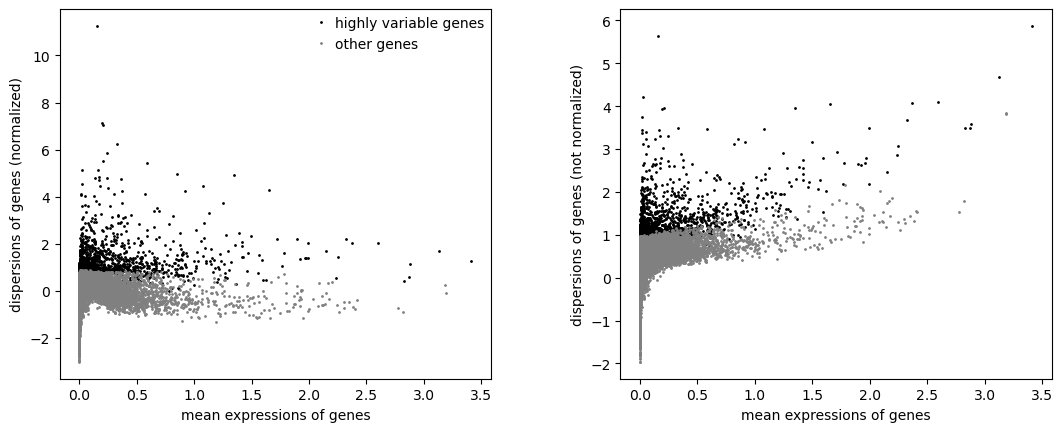

In [60]:
sc.pl.highly_variable_genes(adata)

In [61]:
sc.pp.scale(adata) # z-score
sc.tl.pca(adata)

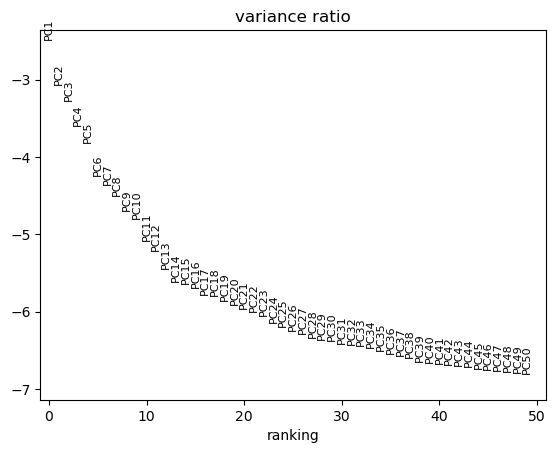

In [62]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

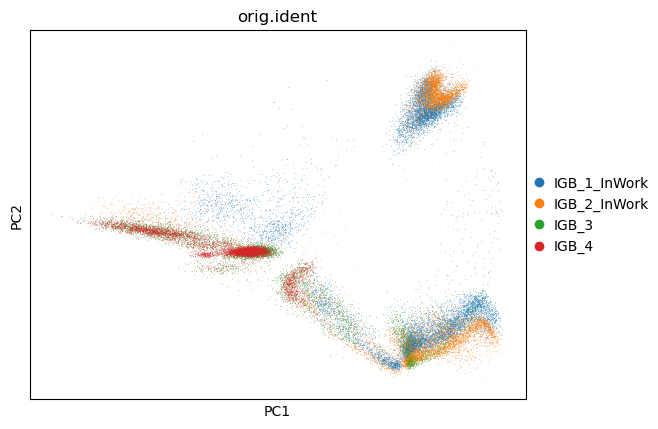

In [63]:
sc.pl.pca(
    adata,
    color=["orig.ident"], #orig.indent - samples feature
    dimensions=[(0, 1)],
    ncols=1,
    size=1,
)

In [64]:
# Run Harmony to correct PCA
sc.external.pp.harmony_integrate(adata, key='orig.ident', max_iter_harmony=20) #correction of batch effect

2025-03-24 12:59:32,540 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-03-24 13:00:20,713 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-03-24 13:00:21,207 - harmonypy - INFO - Iteration 1 of 20
2025-03-24 13:00:54,525 - harmonypy - INFO - Iteration 2 of 20
2025-03-24 13:01:27,803 - harmonypy - INFO - Iteration 3 of 20
2025-03-24 13:02:01,874 - harmonypy - INFO - Iteration 4 of 20
2025-03-24 13:02:35,467 - harmonypy - INFO - Iteration 5 of 20
2025-03-24 13:03:03,671 - harmonypy - INFO - Iteration 6 of 20
2025-03-24 13:03:18,791 - harmonypy - INFO - Iteration 7 of 20
2025-03-24 13:03:32,624 - harmonypy - INFO - Iteration 8 of 20
2025-03-24 13:03:45,245 - harmonypy - INFO - Converged after 8 iterations


In [65]:
# Calculate kNN graph
sc.pp.neighbors(adata, n_pcs=40, use_rep='X_pca_harmony')

# Calculate leiden clusters
sc.tl.leiden(adata)

# Calculate UMAP
sc.tl.umap(adata)

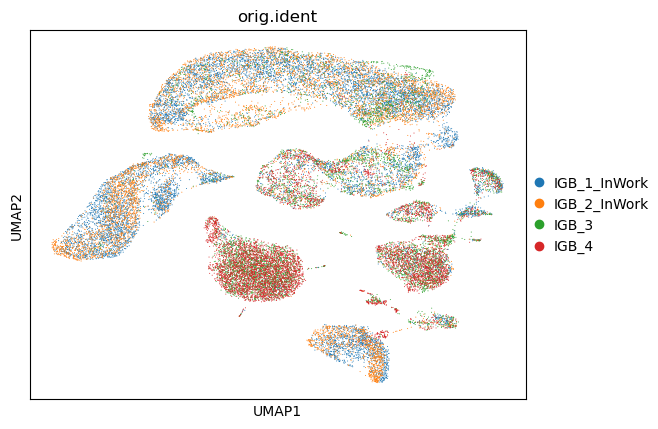

In [66]:
sc.pl.umap(
    adata,
    color="orig.ident",
    size=2,
)

In [67]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)

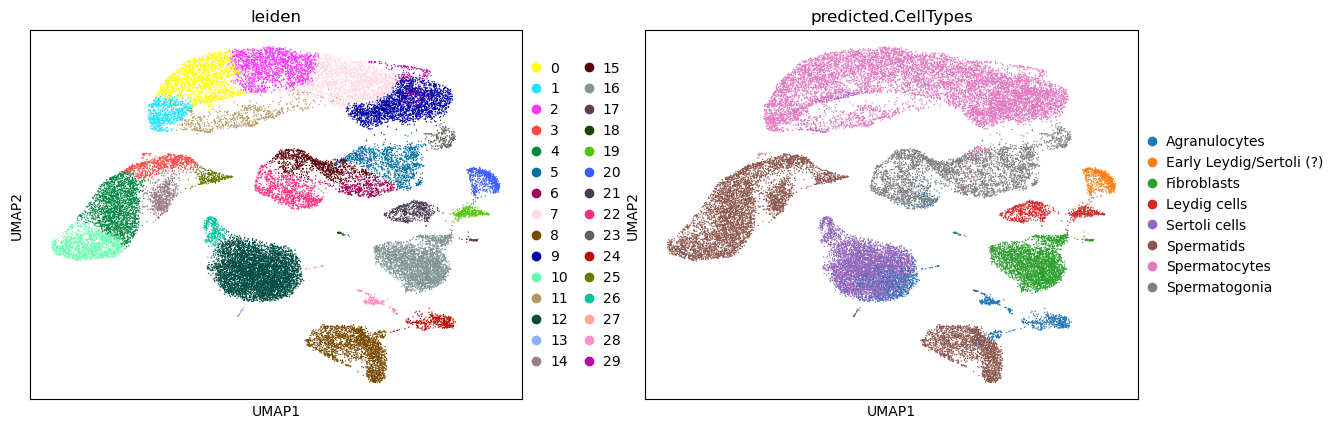

In [68]:
sc.pl.umap(adata, color=["leiden", "predicted.CellTypes"])

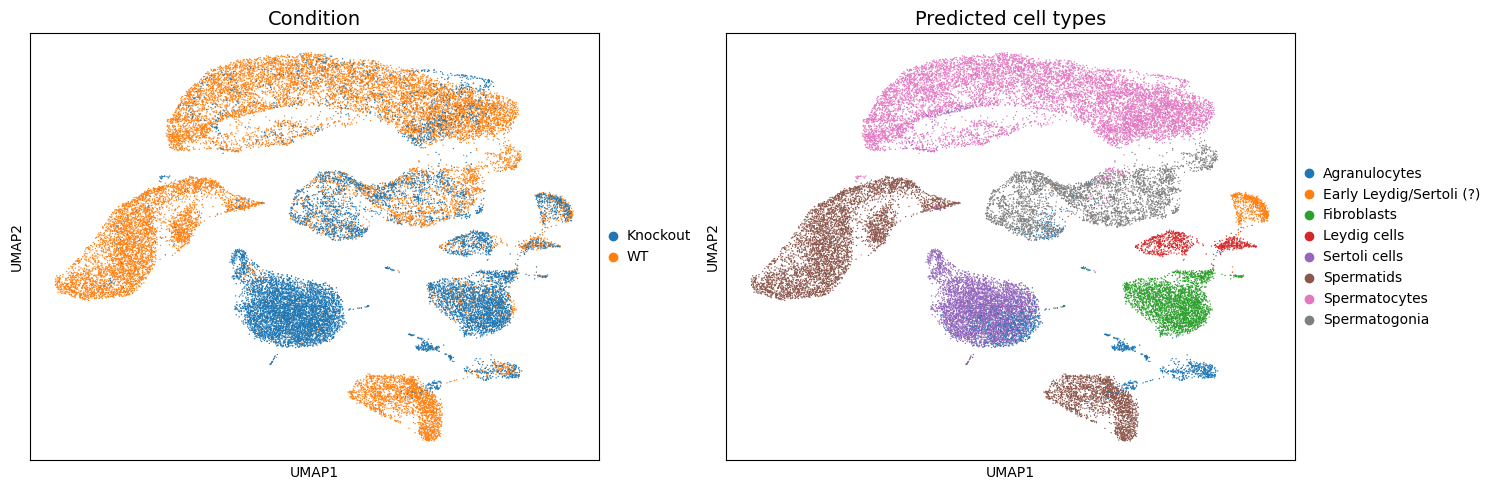

In [70]:
# Ensure Scanpy outputs two separate subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# First UMAP (condition)
sc.pl.umap(adata, color="condition", ax=axes[0], show=False)
axes[0].set_title("Condition", fontsize=14)

# Second UMAP (predicted.CellTypes) with a new title
sc.pl.umap(adata, color="predicted.CellTypes", ax=axes[1], show=False)
axes[1].set_title("Predicted cell types", fontsize=14)

plt.tight_layout()
plt.show()

## DE analysis == pseudobulk

In [38]:
import decoupler as dc

# DESeq2
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats

In [71]:
# Get pseudo-bulk profile
pdata = dc.get_pseudobulk(
    adata,
    sample_col='orig.ident', #== sample
    groups_col='predicted.CellTypes', #==cell type
    layer='raw_count',
    mode='sum', #default
    min_cells=10, #filtration
    min_counts=100 #filtration
)

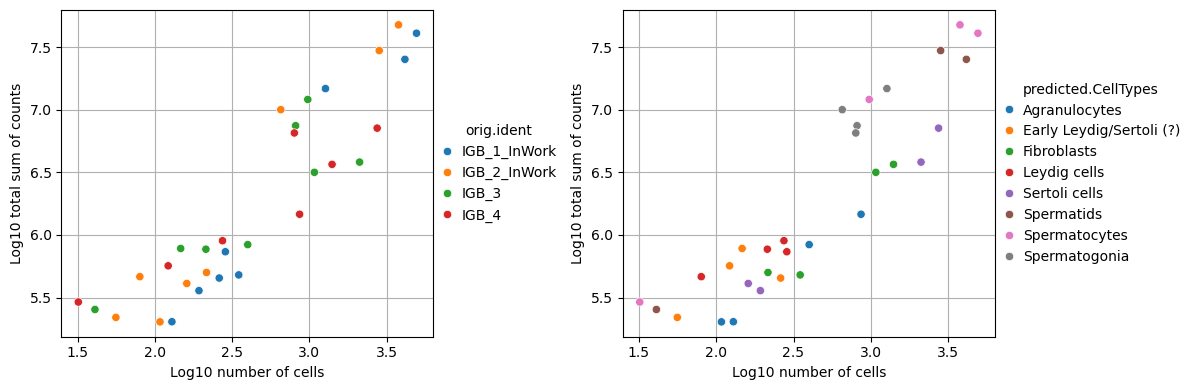

In [72]:
dc.plot_psbulk_samples(pdata, groupby=['orig.ident', 'predicted.CellTypes'], figsize=(12, 4))

In [73]:
# Store raw counts in layers
pdata.layers['counts'] = pdata.X.copy()

# Normalize, scale and compute pca
sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)
sc.pp.scale(pdata, max_value=10)
sc.tl.pca(pdata)

# Return raw counts to X
dc.swap_layer(pdata, 'counts', X_layer_key=None, inplace=True)

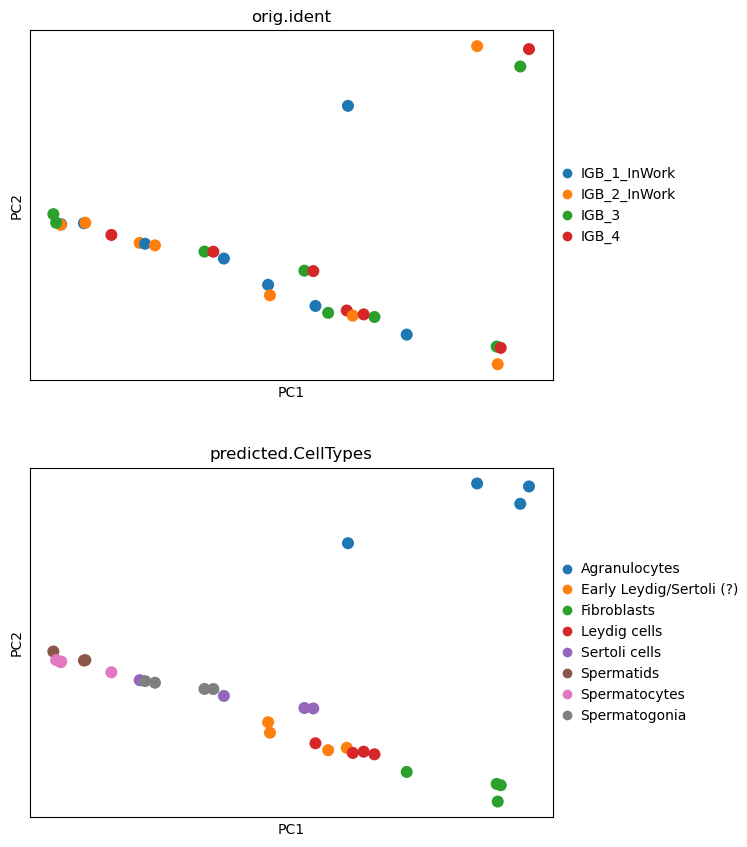

In [74]:
sc.pl.pca(pdata, color=['orig.ident', 'predicted.CellTypes'], ncols=1, size=300)
#We see distribution of samples on PCA according to cell types, not samples 

In [75]:
dc.get_metadata_associations(
    pdata,
    obs_keys = ['samples', 'condition', 'original_cells', 'psbulk_n_cells', 'psbulk_counts'],  # Metadata columns to associate to PCs
    obsm_key='X_pca',  # Where the PCs are stored
    uns_key='pca_anova',  # Where the results are stored
    inplace=True,
)

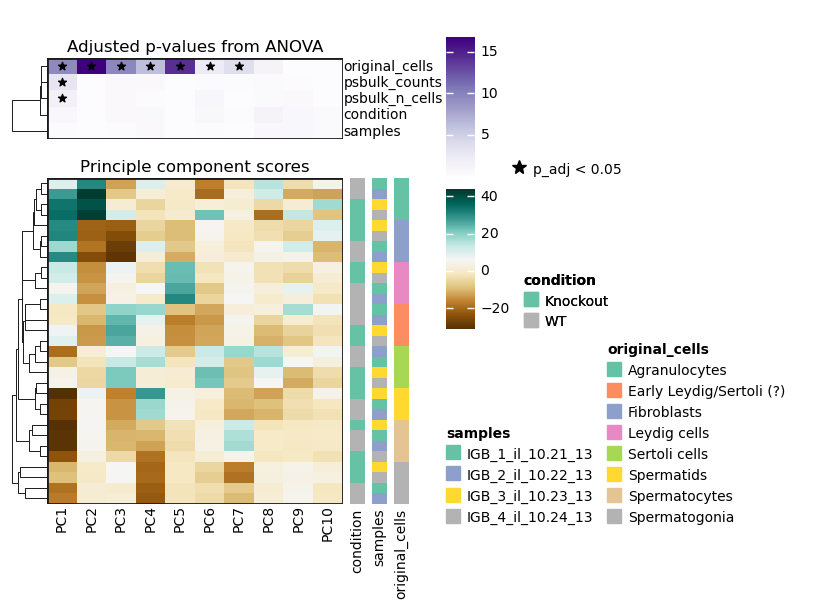

In [76]:
dc.plot_associations(
    pdata,
    uns_key='pca_anova',  # Summary statistics from the anova tests
    obsm_key='X_pca',  # where the PCs are stored
    stat_col='p_adj',  # Which summary statistic to plot
    obs_annotation_cols = ['condition', 'samples', 'original_cells'], # which sample annotations to plot
    titles=['Principle component scores', 'Adjusted p-values from ANOVA'],
    figsize=(7, 5),
    n_factors=10,
)

#Meaning: PCA separates cell types, not condition

I decided to test the code with Leydig cells. Then analysis was performed for all celltypes separatly and together.  

In [77]:
#Get only Leydig cells
leydig = pdata[pdata.obs['original_cells'] == 'Leydig cells'].copy()

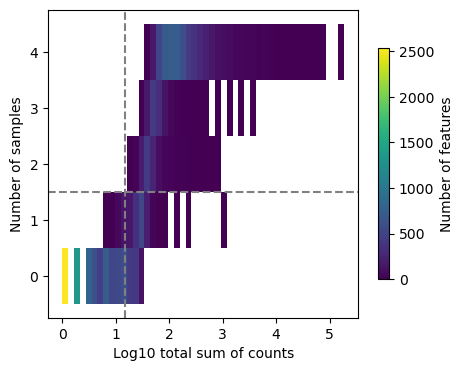

In [78]:
dc.plot_filter_by_expr(leydig, group='condition', min_count=10, min_total_count=15)

In [79]:
#Set filtration parameters 
genes = dc.filter_by_expr(leydig, group='condition', min_count=10, min_total_count=15)

# Filter by these genes
leydig = leydig[:, genes].copy()

In [80]:
# Build DESeq2 object
inference = DefaultInference(n_cpus=1)
dds = DeseqDataSet(
    counts=leydig.X,
    metadata=leydig.obs,
    design='~condition',
    refit_cooks=True,
    inference=inference,
)

In [81]:
csr_matrix(leydig.layers['counts'], dtype=np.float32).toarray()[:4, :10]
#To check if counts are aggregated well

array([[ 24.,  12.,   5.,  26.,  46.,  30., 134., 544.,   5.,  30.],
       [ 15.,  10.,  10.,  19.,  53.,   9.,  74., 586.,  12.,  10.],
       [ 28.,  12.,  12.,  38.,  62.,  19., 127., 647.,  17.,   0.],
       [ 43.,   6.,  13.,  44.,  94.,  33., 116., 377.,  22.,   0.]],
      dtype=float32)

In [82]:
# Compute LFCs
dds.deseq2()

Fitting size factors...
... done in 0.00 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 10.17 seconds.

Fitting dispersion trend curve...
... done in 0.29 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 12.85 seconds.

Fitting LFCs...
... done in 6.40 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



In [83]:
print(dds.varm["LFC"])

      Intercept  condition[T.WT]
0      3.275299        -0.075456
1      1.946961         0.696552
2      2.246811         0.058607
3      3.431934        -0.080442
4      4.062543         0.105991
...         ...              ...
7669   5.855578         2.566081
7670   8.186467         0.816270
7671   8.053726         0.644523
7672   7.649833         0.693440
7673   6.028324         0.734544

[7674 rows x 2 columns]


In [84]:
# Extract contrast between KO and WT
ds_KO_vs_WT = DeseqStats(
    dds,
    contrast=["condition", 'Knockout', 'WT'],
    inference=inference,
)

In [85]:
# Compute Wald test
ds_KO_vs_WT.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: condition Knockout vs WT
         baseMean  log2FoldChange     lfcSE      stat        pvalue  \
0       25.421528        0.108860  0.606659  0.179442  8.575910e-01   
1       10.597094       -1.004912  0.895825 -1.121773  2.619589e-01   
2        9.859082       -0.084552  0.922729 -0.091633  9.269896e-01   
3       29.749836        0.116053  0.568481  0.204145  8.382400e-01   
4       61.535375       -0.152912  0.468758 -0.326207  7.442678e-01   
...           ...             ...       ...       ...           ...   
7669  2446.727132       -3.702073  0.429556 -8.618364  6.791726e-18   
7670  5858.466738       -1.177629  0.342710 -3.436227  5.898760e-04   
7671  4568.654594       -0.929850  0.403079 -2.306865  2.106236e-02   
7672  3150.658313       -1.000422  0.387451 -2.582059  9.821293e-03   
7673   639.967230       -1.059723  1.118996 -0.947031  3.436230e-01   

              padj  
0     9.964027e-01  
1     9.964027e-01  
2     9.969305e-01  


... done in 2.12 seconds.



In [86]:
ds_KO_vs_WT.lfc_shrink(coeff="condition[T.WT]")

Fitting MAP LFCs...


Shrunk log2 fold change & Wald test p-value: condition[T.WT]
         baseMean  log2FoldChange     lfcSE      stat        pvalue  \
0       25.421528       -0.019305  0.325955  0.179442  8.575910e-01   
1       10.597094        0.095059  0.425408 -1.121773  2.619589e-01   
2        9.859082        0.007486  0.360400 -0.091633  9.269896e-01   
3       29.749836       -0.022887  0.320023  0.204145  8.382400e-01   
4       61.535375        0.041605  0.306996 -0.326207  7.442678e-01   
...           ...             ...       ...       ...           ...   
7669  2446.727132        3.601894  0.432660 -8.618364  6.791726e-18   
7670  5858.466738        0.972449  0.356225 -3.436227  5.898760e-04   
7671  4568.654594        0.542452  0.426683 -2.306865  2.106236e-02   
7672  3150.658313        0.671582  0.411909 -2.582059  9.821293e-03   
7673   639.967230        0.064243  0.468157 -0.947031  3.436230e-01   

              padj  
0     9.964027e-01  
1     9.964027e-01  
2     9.969305e-01  
3 

... done in 15.70 seconds.



In [87]:
# Extract results
results_df = ds_KO_vs_WT.results_df
results_df.index = leydig.var.index
results_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0610009B22Rik,25.421528,-0.019305,0.325955,0.179442,8.575910e-01,9.964027e-01
0610009L18Rik,10.597094,0.095059,0.425408,-1.121773,2.619589e-01,9.964027e-01
0610010F05Rik,9.859082,0.007486,0.360400,-0.091633,9.269896e-01,9.969305e-01
0610010K14Rik,29.749836,-0.022887,0.320023,0.204145,8.382400e-01,9.964027e-01
0610012G03Rik,61.535375,0.041605,0.306996,-0.326207,7.442678e-01,9.964027e-01
...,...,...,...,...,...,...
mt-Nd3,2446.727132,3.601894,0.432660,-8.618364,6.791726e-18,1.277693e-14
mt-Nd4,5858.466738,0.972449,0.356225,-3.436227,5.898760e-04,2.399361e-02
mt-Nd4l,4568.654594,0.542452,0.426683,-2.306865,2.106236e-02,3.083546e-01
mt-Nd5,3150.658313,0.671582,0.411909,-2.582059,9.821293e-03,1.785989e-01


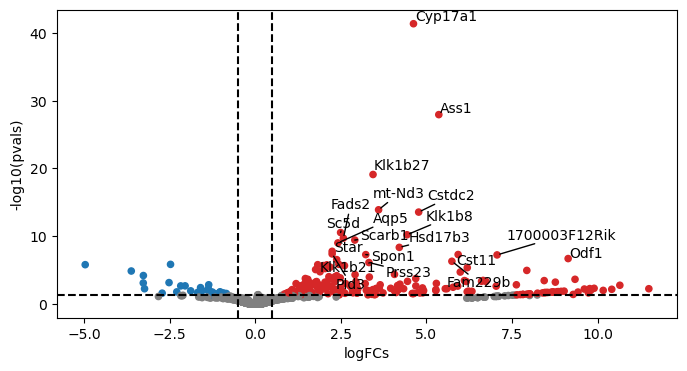

In [70]:
dc.plot_volcano_df(
    results_df,
    x='log2FoldChange',
    y='padj',
    top=20,
    figsize=(8, 4)
)

In [88]:
significant = results_df[abs(results_df['padj']) < 0.05]
sc_leydig = significant.index
len(sc_leydig)

#Meaning: 245 DEGs for Leydig cells - WT/KO conditions

245

In [89]:
bulk = pd.read_csv('DEGs_from_bulkRNAseq.csv')

In [90]:
leydig_bulk_intersection = list(set(sc_leydig) & set(bulk['x']))
len(leydig_bulk_intersection)

#Meaning: intersection between bulk RNA seq DEGs and Leydig cells == 30

30

## Making cell-type-universal code

In [91]:
bulk = pd.read_csv('DEGs_from_bulkRNAseq.csv') #for intersection

set(pdata.obs['original_cells'])

{'Agranulocytes',
 'Early Leydig/Sertoli (?)',
 'Fibroblasts',
 'Leydig cells',
 'Sertoli cells',
 'Spermatids',
 'Spermatocytes',
 'Spermatogonia'}

In [93]:
#Because python doesn't like special symbols
pdata.obs['original_cells'] = pdata.obs['original_cells'].astype(str)
pdata.obs.loc[pdata.obs['original_cells'] == 'Early Leydig/Sertoli (?)', 'original_cells'] = 'Early Leydig_or_Sertoli_maybe'


Fitting size factors...
... done in 0.00 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 13.34 seconds.

Fitting dispersion trend curve...
... done in 0.44 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 16.63 seconds.

Fitting LFCs...
... done in 7.80 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 2.66 seconds.



Log2 fold change & Wald test p-value: condition Knockout vs WT
         baseMean  log2FoldChange     lfcSE      stat        pvalue  \
0       25.421528        0.108860  0.606659  0.179442  8.575910e-01   
1       10.597094       -1.004912  0.895825 -1.121773  2.619589e-01   
2        9.859082       -0.084552  0.922729 -0.091633  9.269896e-01   
3       29.749836        0.116053  0.568481  0.204145  8.382400e-01   
4       61.535375       -0.152912  0.468758 -0.326207  7.442678e-01   
...           ...             ...       ...       ...           ...   
7669  2446.727132       -3.702073  0.429556 -8.618364  6.791726e-18   
7670  5858.466738       -1.177629  0.342710 -3.436227  5.898760e-04   
7671  4568.654594       -0.929850  0.403079 -2.306865  2.106236e-02   
7672  3150.658313       -1.000422  0.387451 -2.582059  9.821293e-03   
7673   639.967230       -1.059723  1.118996 -0.947031  3.436230e-01   

              padj  
0     9.964027e-01  
1     9.964027e-01  
2     9.969305e-01  


Fitting MAP LFCs...
... done in 20.65 seconds.



Shrunk log2 fold change & Wald test p-value: condition[T.WT]
         baseMean  log2FoldChange     lfcSE      stat        pvalue  \
0       25.421528       -0.019305  0.325955  0.179442  8.575910e-01   
1       10.597094        0.095059  0.425408 -1.121773  2.619589e-01   
2        9.859082        0.007486  0.360400 -0.091633  9.269896e-01   
3       29.749836       -0.022887  0.320023  0.204145  8.382400e-01   
4       61.535375        0.041605  0.306996 -0.326207  7.442678e-01   
...           ...             ...       ...       ...           ...   
7669  2446.727132        3.601894  0.432660 -8.618364  6.791726e-18   
7670  5858.466738        0.972449  0.356225 -3.436227  5.898760e-04   
7671  4568.654594        0.542452  0.426683 -2.306865  2.106236e-02   
7672  3150.658313        0.671582  0.411909 -2.582059  9.821293e-03   
7673   639.967230        0.064243  0.468157 -0.947031  3.436230e-01   

              padj  
0     9.964027e-01  
1     9.964027e-01  
2     9.969305e-01  
3 

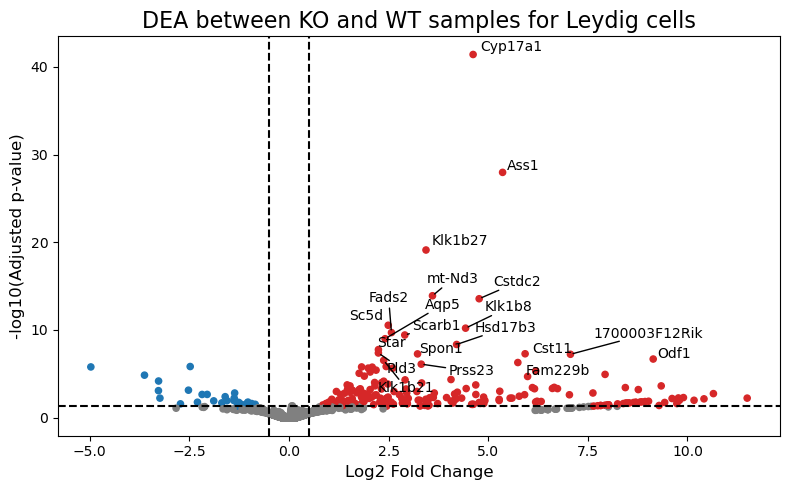

significantly DE genes for  Leydig cells , intersected with bulk DEGs:
['Lhcgr', 'Spon1', 'Fads2', 'Col11a1', 'Plp1', 'Cst3', 'Lmo4', 'Fads1', 'Cav1', 'Fbn1', 'Ass1', 'Ccnd2', 'Tst', 'Ccl27a', 'Gpx1', 'Igfbp2', 'Gng12', 'Glul', 'Mtss2', 'Csrp2', 'Akap12', 'Htra1', 'Id1', 'Actr3b', 'Eif4g3', 'Gucy1a1', 'Dpp6', 'Inf2', 'Abca1', 'Ptn']
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 16.58 seconds.

Fitting dispersion trend curve...
... done in 0.52 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 15.48 seconds.

Fitting LFCs...
... done in 7.68 seconds.

Calculating cook's distance...
... done in 0.04 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 2.65 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: condition Knockout vs WT
         baseMean  log2FoldChange     lfcSE      stat        pvalue      padj
0       11.833593        4.241113  1.722687  2.461917  1.381966e-02  0.158464
1       12.832333       -1.782572  1.011600 -1.762132  7.804697e-02  0.495938
2       14.118001       -0.506454  0.949670 -0.533295  5.938296e-01  0.980997
3       26.702850        0.107361  0.846720  0.126796  8.991020e-01  0.995973
4       60.386607        0.065146  0.646072  0.100834  9.196825e-01  0.995973
...           ...             ...       ...       ...           ...       ...
7368   690.254286       -3.423417  0.660408 -5.183793  2.174185e-07  0.000017
7369  1348.852737       -0.675848  0.609873 -1.108178  2.677848e-01  0.858010
7370  1065.818095       -0.595152  0.618889 -0.961646  3.362276e-01  0.905040
7371   636.379264       -0.647470  0.609711 -1.061929  2.882678e-01  0.869125
7372   110.032310       -0.527325  0.664042 -0.794115  4.271288e-01  0.950421



... done in 17.24 seconds.



Shrunk log2 fold change & Wald test p-value: condition[T.WT]
         baseMean  log2FoldChange     lfcSE      stat        pvalue      padj
0       11.833593       -2.683779  1.692481  2.461917  1.381966e-02  0.158464
1       12.832333        0.713248  0.969134 -1.762132  7.804697e-02  0.495938
2       14.118001        0.170911  0.676698 -0.533295  5.938296e-01  0.980997
3       26.702850       -0.039821  0.612101  0.126796  8.991020e-01  0.995973
4       60.386607       -0.032260  0.524874  0.100834  9.196825e-01  0.995973
...           ...             ...       ...       ...           ...       ...
7368   690.254286        3.173289  0.673365 -5.183793  2.174185e-07  0.000017
7369  1348.852737        0.395676  0.552494 -1.108178  2.677848e-01  0.858010
7370  1065.818095        0.338553  0.550490 -0.961646  3.362276e-01  0.905040
7371   636.379264        0.376980  0.549335 -1.061929  2.882678e-01  0.869125
7372   110.032310        0.275858  0.569086 -0.794115  4.271288e-01  0.950421

[7

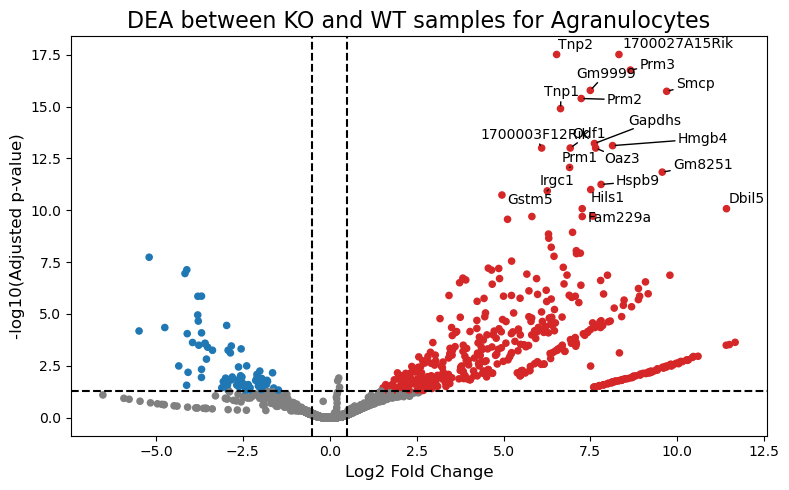

significantly DE genes for  Agranulocytes , intersected with bulk DEGs:
['Srcin1', 'Fyn', 'Tmsb10', 'Lpl', 'Tpd52l1', 'Id2', 'Prdx6', 'Chd5', 'Ccl27a', 'S100a11', 'Vim', 'Akap12', 'Osbp2', 'Cyp26b1', 'Trim36', 'Gamt', 'Zfp37', 'Rimklb', 'Kctd16', 'Syap1']
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 23.15 seconds.

Fitting dispersion trend curve...
... done in 0.60 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 22.89 seconds.

Fitting LFCs...
... done in 11.28 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.72 seconds.



Log2 fold change & Wald test p-value: condition Knockout vs WT
          baseMean  log2FoldChange     lfcSE      stat        pvalue  \
0        30.865391        1.006971  0.748588  1.345162  1.785731e-01   
1        20.155402       -0.465036  0.934011 -0.497891  6.185605e-01   
2        10.131519        3.949413  1.800898  2.193025  2.830561e-02   
3        55.788003        0.222090  0.549144  0.404430  6.858965e-01   
4        95.026135        0.058520  0.454566  0.128738  8.975652e-01   
...            ...             ...       ...       ...           ...   
10769  1478.800337       -2.778603  0.362414 -7.666924  1.761706e-14   
10770  3549.575114       -0.144093  0.284801 -0.505944  6.128957e-01   
10771  2613.365495        0.095585  0.321616  0.297201  7.663133e-01   
10772  1687.164324        0.114354  0.305671  0.374109  7.083233e-01   
10773   297.260989       -0.178113  0.375953 -0.473765  6.356676e-01   

               padj  
0      8.713525e-01  
1      9.992770e-01  
2     

Fitting MAP LFCs...
... done in 26.11 seconds.



Shrunk log2 fold change & Wald test p-value: condition[T.WT]
          baseMean  log2FoldChange     lfcSE      stat        pvalue  \
0        30.865391       -0.224108  0.463588  1.345162  1.785731e-01   
1        20.155402        0.063588  0.462611 -0.497891  6.185605e-01   
2        10.131519       -0.256708  0.536538  2.193025  2.830561e-02   
3        55.788003       -0.069046  0.365870  0.404430  6.858965e-01   
4        95.026135       -0.022661  0.333403  0.128738  8.975652e-01   
...            ...             ...       ...       ...           ...   
10769  1478.800337        2.686860  0.365453 -7.666924  1.761706e-14   
10770  3549.575114        0.091575  0.252564 -0.505944  6.128957e-01   
10771  2613.365495       -0.053589  0.273716  0.297201  7.663133e-01   
10772  1687.164324       -0.067354  0.264046  0.374109  7.083233e-01   
10773   297.260989        0.088674  0.307997 -0.473765  6.356676e-01   

               padj  
0      8.713525e-01  
1      9.992770e-01  
2      2

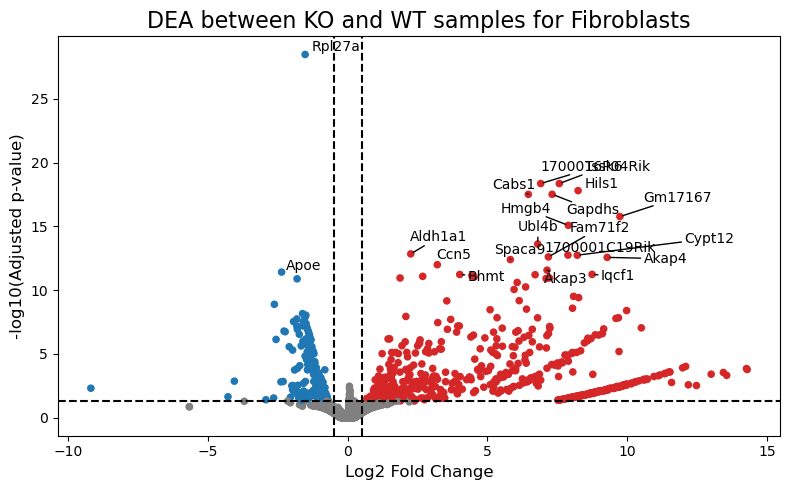

significantly DE genes for  Fibroblasts , intersected with bulk DEGs:
['Srcin1', 'Rpl23', 'Col22a1', 'Spon1', 'Flrt2', 'Fzd9', 'Rpl36a', 'Adamts1', 'Cst3', 'Rpl35', '5031439G07Rik', 'Rps3a1', 'Npm1', 'Ppfibp1', 'Nr2f2', 'Itga9', 'Rps15', 'Map2', 'Ndrg2', 'Syt1', 'Cxcl12', 'Rps2', 'Gpi1', 'Cdh11', 'Rpl12', 'Fcgr2b', 'Fbn1', 'Rpl10a', 'Rps6', 'Anxa6', 'Rpl4', 'Paqr9', 'Id2', 'Papss2', 'Idh1', 'Chd5', 'Id3', 'Bambi', 'Ccn2', 'Rps24', 'Rack1', 'Knstrn', 'Dynll2', 'Glul', 'Mtss2', 'Cyp1b1', 'Vim', 'Fn1', 'Akap12', 'Osbp2', 'Spag4', 'Tent5a', 'Nrn1', 'Id1', 'Trim36', 'Sulf2', 'Cyp26b1', 'Rps4x', 'Mapk6', 'Rpl10', 'Rpl7a', 'Rps10', 'Npy']
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 18.93 seconds.

Fitting dispersion trend curve...
... done in 0.61 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 25.08 seconds.

Fitting LFCs...
... done in 11.94 seconds.

Calculating cook's distance...
... done in 0.04 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 4.48 seconds.



Log2 fold change & Wald test p-value: condition Knockout vs WT
          baseMean  log2FoldChange     lfcSE      stat        pvalue      padj
0       149.669761        0.050309  0.722784  0.069605  9.445082e-01       NaN
1      1151.869688       -1.107105  0.448602 -2.467897  1.359094e-02  0.048146
2        11.916843       -2.929817  3.851115 -0.760771  4.467938e-01       NaN
3         3.193502       -1.028963  4.724179 -0.217808  8.275789e-01       NaN
4       491.724728       -1.535678  0.571939 -2.685038  7.252154e-03  0.030221
...            ...             ...       ...       ...           ...       ...
11584   960.376366       -2.617797  0.533085 -4.910656  9.077233e-07  0.000047
11585  1168.198706       -0.838224  0.428626 -1.955608  5.051133e-02  0.123018
11586  1219.658113       -0.222079  0.460651 -0.482097  6.297368e-01  0.734428
11587   592.852845       -0.745737  0.519810 -1.434634  1.513913e-01  0.268550
11588   215.877116       -1.025727  0.808471 -1.268725  2.045390e-01

Fitting MAP LFCs...
... done in 35.82 seconds.



Shrunk log2 fold change & Wald test p-value: condition[T.WT]
          baseMean  log2FoldChange     lfcSE      stat        pvalue      padj
0       149.669761       -0.017729  0.624808  0.069605  9.445082e-01       NaN
1      1151.869688        0.864433  0.456528 -2.467897  1.359094e-02  0.048146
2        11.916843        0.120041  1.716000 -0.760771  4.467938e-01       NaN
3         3.193502        0.036282  1.855795 -0.217808  8.275789e-01       NaN
4       491.724728        1.169360  0.579613 -2.685038  7.252154e-03  0.030221
...            ...             ...       ...       ...           ...       ...
11584   960.376366        2.412413  0.534265 -4.910656  9.077233e-07  0.000047
11585  1168.198706        0.627646  0.429779 -1.955608  5.051133e-02  0.123018
11586  1219.658113        0.139996  0.430373 -0.482097  6.297368e-01  0.734428
11587   592.852845        0.471820  0.509362 -1.434634  1.513913e-01  0.268550
11588   215.877116        0.406904  0.757734 -1.268725  2.045390e-01  

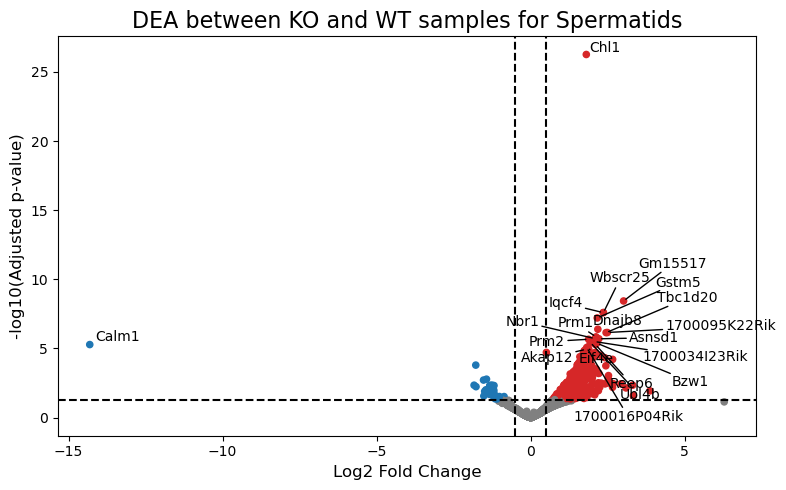

significantly DE genes for  Spermatids , intersected with bulk DEGs:
['Rpl6', 'Nelfe', 'Rpl35', '5031439G07Rik', 'Ube2k', 'Dzip1', 'Gabarap', 'Gpi1', 'Rpl12', 'Spag9', 'Rpl41', 'Bmi1', 'Tulp4', 'Ppm1a', 'Camk2n1', 'Socs7', 'Pafah1b1', 'Atp1b3', 'Dynll2', 'Glul', 'Srpk2', 'Slc30a4', 'Aldoa', 'Gm10076', 'Akap12', 'Osbp2', 'Cdkn1c', 'Fem1b', 'Tmsb4x', 'Ahi1', 'Mapk6', 'Eya4', 'Eef1g', 'Nsa2', 'Ldha', 'Rps15']
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 33.77 seconds.

Fitting dispersion trend curve...
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.55 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 33.00 seconds.

Fitting LFCs...
... done in 30.66 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.91 seconds.



Log2 fold change & Wald test p-value: condition Knockout vs WT
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0       828.359375        0.011171  0.493068  0.022657  0.981924  0.999970
1       174.587063        0.524810  0.577851  0.908211  0.363767  0.999970
2      3376.812763        0.420499  0.468405  0.897725  0.369332  0.999970
3       572.476809       -0.064038  0.580965 -0.110228  0.912229  0.999970
4        82.770320        1.552018  1.021828  1.518865  0.128796  0.999970
...            ...             ...       ...       ...       ...       ...
15779   910.862991       -3.887742  0.803792 -4.836751  0.000001  0.005208
15780  2519.470907       -0.700480  0.563840 -1.242338  0.214112  0.999970
15781  1572.899347       -0.509243  0.775422 -0.656731  0.511354  0.999970
15782   711.343423       -1.133428  0.556867 -2.035366  0.041814  0.999970
15783   154.407942       -1.261264  0.774336 -1.628834  0.103348  0.999970

[15784 rows x 6 columns]


Fitting MAP LFCs...
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/utils.py:1087: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
... done in 90.10 seconds.



Shrunk log2 fold change & Wald test p-value: condition[T.WT]
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0       828.359375   -3.575421e-08  0.001485  0.022657  0.981924  0.999970
1       174.587063   -1.596803e-06  0.001458  0.908211  0.363767  0.999970
2      3376.812763   -1.970827e-06  0.001360  0.897725  0.369332  0.999970
3       572.476809   -1.537641e-07  0.001507 -0.110228  0.912229  0.999970
4        82.770320   -1.344113e-06  0.001304  1.518865  0.128796  0.999970
...            ...             ...       ...       ...       ...       ...
15779   910.862991    3.541810e+00  0.808010 -4.836751  0.000001  0.005208
15780  2519.470907    2.297262e-06  0.001663 -1.242338  0.214112  0.999970
15781  1572.899347    8.927743e-07  0.001595 -0.656731  0.511354  0.999970
15782   711.343423    3.275321e-06  0.001853 -2.035366  0.041814  0.999970
15783   154.407942    2.066266e-06  0.001964 -1.628834  0.103348  0.999970

[15784 rows x 6 columns]


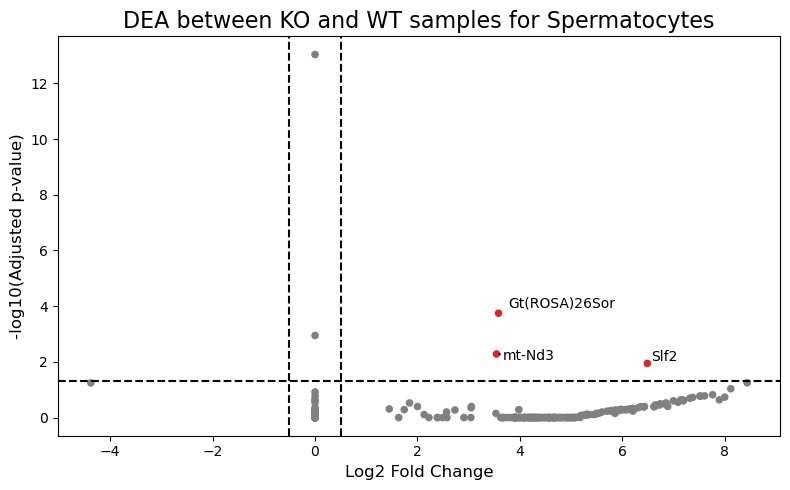

significantly DE genes for  Spermatocytes , intersected with bulk DEGs:
[]
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 25.86 seconds.

Fitting dispersion trend curve...
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.61 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 24.62 seconds.

Fitting LFCs...
... done in 12.45 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.99 seconds.



Log2 fold change & Wald test p-value: condition Knockout vs WT
          baseMean  log2FoldChange     lfcSE      stat        pvalue      padj
0        86.727931        0.730296  0.690897  1.057026  2.904998e-01  0.540472
1        93.935120       -2.266290  0.827823 -2.737649  6.188002e-03  0.036978
2        42.943791        0.088061  0.637377  0.138162  8.901123e-01  0.951265
3        51.602774        1.154095  0.552551  2.088666  3.673783e-02  0.147076
4       161.649307        0.699247  0.498514  1.402662  1.607176e-01  0.383647
...            ...             ...       ...       ...           ...       ...
10608  4860.400228       -4.754565  0.853594 -5.570057  2.546556e-08  0.000001
10609  6379.264618       -1.661147  0.482797 -3.440678  5.802592e-04  0.004931
10610  4995.778362       -1.172413  0.805514 -1.455485  1.455351e-01  0.361048
10611  2490.549686       -1.448607  0.755041 -1.918580  5.503748e-02  0.193415
10612   706.496739       -1.239262  0.940260 -1.317999  1.875040e-01

Fitting MAP LFCs...
... done in 27.31 seconds.



Shrunk log2 fold change & Wald test p-value: condition[T.WT]
          baseMean  log2FoldChange     lfcSE      stat        pvalue      padj
0        86.727931       -0.517953  0.634458  1.057026  2.904998e-01  0.540472
1        93.935120        1.804089  0.847601 -2.737649  6.188002e-03  0.036978
2        42.943791       -0.062139  0.571711  0.138162  8.901123e-01  0.951265
3        51.602774       -0.960079  0.532012  2.088666  3.673783e-02  0.147076
4       161.649307       -0.578623  0.478007  1.402662  1.607176e-01  0.383647
...            ...             ...       ...       ...           ...       ...
10608  4860.400228        4.466419  0.867609 -5.570057  2.546556e-08  0.000001
10609  6379.264618        1.501559  0.483988 -3.440678  5.802592e-04  0.004931
10610  4995.778362        0.798520  0.769276 -1.455485  1.455351e-01  0.361048
10611  2490.549686        1.076297  0.743905 -1.918580  5.503748e-02  0.193415
10612   706.496739        0.744816  0.882064 -1.317999  1.875040e-01  

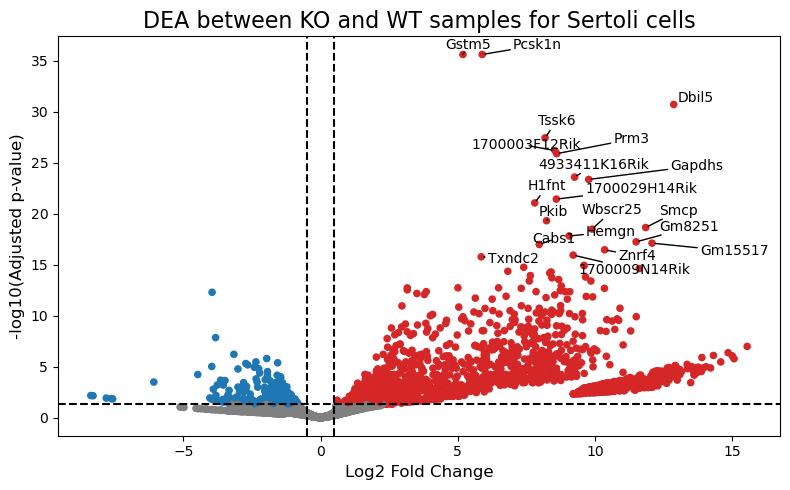

significantly DE genes for  Sertoli cells , intersected with bulk DEGs:
['Flrt1', 'Iqsec1', 'Srcin1', 'Slco3a1', 'Pex5l', 'Ost4', 'Fzd9', 'Cmip', 'Rps3a1', 'Khdrbs3', 'Laptm4b', 'Fads1', 'Ppp2r1b', 'Sbk1', 'Tulp4', 'Pias2', 'Penk', 'Cnn3', 'Camk2n1', 'Specc1', 'Cpeb2', 'Tor1aip1', 'Kcnb1', 'Atp1b3', 'Nabp1', 'Tbpl1', 'Pak6', 'Tuba4a', 'Vim', 'Baz1a', 'Pnpla6', 'Impdh2', 'Tes', 'Rhoc', 'Got1', 'Abcd2', 'Eif4g3', 'Hdac11', 'Plcb1', 'Pgam1', 'Pou6f1', 'Kctd16', 'Trp53inp2', 'Cxxc5', 'Mcm7', 'Rps10', 'Chd7', 'Ptprg', 'Myl12a', 'Pdlim4', 'Tiam1', 'Plagl1', 'Mfge8', 'Nectin1', 'Dcaf7', 'Tmx1', 'Wdtc1', 'Actg1', 'Gapdh', 'Paqr9', 'Acadl', 'Chd5', 'Notch1', 'Ccl27a', 'Cfl1', 'Ndufc2', 'Scamp1', 'Pls3', 'Trim36', 'Ace', 'Tmsb4x', 'Rps4x', 'Dbi', 'Rimklb', 'Soat1', 'Anxa5', 'Dbf4', 'Fam234b', '6430548M08Rik', 'Sall3', 'Col22a1', 'Nexn', 'Osbpl9', 'Ttll7', 'Ube2k', 'Mtch1', 'Ica1l', 'Tceal3', 'Phgdh', 'Ccdc184', 'Prr13', 'Enpp2', 'Mpst', 'Prdx6', 'Reln', 'Dtd1', 'Qdpr', 'Rack1', 'N6amt1', 'Tcfl5'

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 13.96 seconds.

Fitting dispersion trend curve...
... done in 0.34 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 14.44 seconds.

Fitting LFCs...
... done in 7.95 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 2.59 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: condition Knockout vs WT
         baseMean  log2FoldChange     lfcSE      stat        pvalue  \
0        8.128150       -2.811020  1.245094 -2.257676  2.396586e-02   
1       20.119202        0.377847  0.787285  0.479936  6.312728e-01   
2       12.176668       -0.197226  0.968217 -0.203700  8.385880e-01   
3       21.229168        0.159594  0.809209  0.197222  8.436536e-01   
4       20.200347       -0.048220  0.783178 -0.061569  9.509060e-01   
...           ...             ...       ...       ...           ...   
7310  2434.927905       -3.544051  0.472856 -7.494988  6.630439e-14   
7311  4108.514528       -0.276506  0.399269 -0.692530  4.886046e-01   
7312  3870.460414        0.011717  0.495568  0.023643  9.811372e-01   
7313  1966.274669       -0.454286  0.465317 -0.976292  3.289198e-01   
7314   786.545173       -0.193635  0.524782 -0.368983  7.121406e-01   

              padj  
0     2.462223e-01  
1     9.731845e-01  
2     9.893763e-01  


... done in 17.52 seconds.



Shrunk log2 fold change & Wald test p-value: condition[T.WT]
         baseMean  log2FoldChange     lfcSE      stat        pvalue  \
0        8.128150        0.422336  1.102525 -2.257676  2.396586e-02   
1       20.119202       -0.093478  0.480595  0.479936  6.312728e-01   
2       12.176668        0.035700  0.526430 -0.203700  8.385880e-01   
3       21.229168       -0.037203  0.484961  0.197222  8.436536e-01   
4       20.200347        0.012592  0.483115 -0.061569  9.509060e-01   
...           ...             ...       ...       ...           ...   
7310  2434.927905        3.419829  0.476975 -7.494988  6.630439e-14   
7311  4108.514528        0.159408  0.348127 -0.692530  4.886046e-01   
7312  3870.460414       -0.003866  0.389896  0.023643  9.811372e-01   
7313  1966.274669        0.234130  0.403580 -0.976292  3.289198e-01   
7314   786.545173        0.083526  0.411070 -0.368983  7.121406e-01   

              padj  
0     2.462223e-01  
1     9.731845e-01  
2     9.893763e-01  
3 

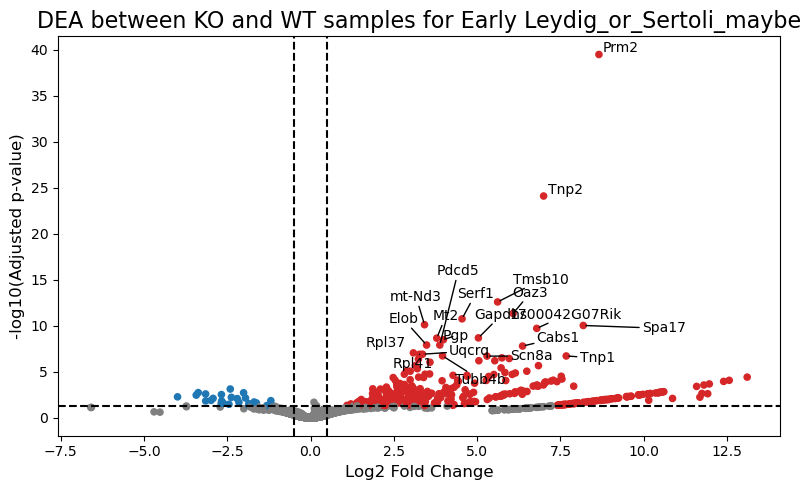

significantly DE genes for  Early Leydig_or_Sertoli_maybe , intersected with bulk DEGs:
['Fam234b', 'Tiam1', 'Rpl6', 'Sall3', 'Calm3', 'Rpl35', 'Cst3', 'Tmsb10', 'Gpi1', 'Mt2', 'Rpl41', 'Tpi1', 'Hk2', 'Notch1', 'Reln', 'Ccl27a', 'Rps24', 'Mt1', 'Atp1a2', 'Knstrn', 'Dynll2', 'Alcam', 'Gm10076', 'Osbp2', 'Sub1', 'Thra', 'Sema6a', 'Hdgfl3', 'Peg3', 'Dab1', 'Ldha', 'Sorbs2', 'Rps15', 'Chd7']
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 27.88 seconds.

Fitting dispersion trend curve...
... done in 0.79 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 32.10 seconds.

Fitting LFCs...
... done in 15.67 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.42 seconds.



Log2 fold change & Wald test p-value: condition Knockout vs WT
           baseMean  log2FoldChange     lfcSE      stat        pvalue  \
0        487.792054       -1.036122  0.360292 -2.875785  4.030244e-03   
1         99.651464       -1.621933  0.543131 -2.986267  2.824063e-03   
2       2499.401764       -2.915267  0.420615 -6.930958  4.180016e-12   
3        633.602392       -1.496019  0.346397 -4.318804  1.568770e-05   
4        475.154887        1.893877  0.401495  4.717059  2.392784e-06   
...             ...             ...       ...       ...           ...   
13630   7177.075663       -1.785038  0.357216 -4.997080  5.820502e-07   
13631  19486.711021        0.535772  0.317982  1.684910  9.200598e-02   
13632  13509.792406        1.061188  0.303460  3.496964  4.705862e-04   
13633   6402.044722        0.703519  0.301375  2.334363  1.957673e-02   
13634   1003.239737        0.674571  0.379998  1.775197  7.586544e-02   

               padj  
0      1.346542e-02  
1      9.998988e

Fitting MAP LFCs...
... done in 37.06 seconds.



Shrunk log2 fold change & Wald test p-value: condition[T.WT]
           baseMean  log2FoldChange     lfcSE      stat        pvalue  \
0        487.792054        0.954488  0.357457 -2.875785  4.030244e-03   
1         99.651464        1.419367  0.543473 -2.986267  2.824063e-03   
2       2499.401764        2.817223  0.422814 -6.930958  4.180016e-12   
3        633.602392        1.413957  0.346358 -4.318804  1.568770e-05   
4        475.154887       -1.782916  0.403137  4.717059  2.392784e-06   
...             ...             ...       ...       ...           ...   
13630   7177.075663        1.699232  0.357989 -4.997080  5.820502e-07   
13631  19486.711021       -0.493873  0.312432  1.684910  9.200598e-02   
13632  13509.792406       -1.003487  0.301979  3.496964  4.705862e-04   
13633   6402.044722       -0.655717  0.297770  2.334363  1.957673e-02   
13634   1003.239737       -0.602244  0.372122  1.775197  7.586544e-02   

               padj  
0      1.346542e-02  
1      9.998988e-0

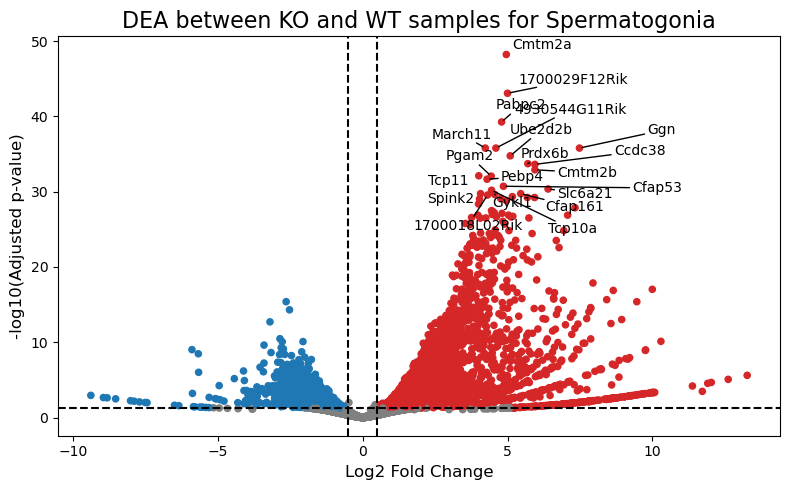

significantly DE genes for  Spermatogonia , intersected with bulk DEGs:
['Actr2', 'Txnip', 'Ahdc1', 'Myo10', 'Bcas1', 'Penk', 'Gabra1', 'Tmeff1', 'Specc1', 'Ablim3', 'Slc1a3', 'Atp2b1', 'Tbpl1', 'Msto1', 'Impdh2', 'Arrdc3', 'Eif4g3', 'Shroom2', 'Ahi1', 'Vegfb', 'Pgam1', 'Ppp1r8', 'Tut4', 'Kpna4', 'Cisd2', 'Cxxc5', 'Pxdc1', 'Snrpn', 'Nfe2l2', 'Ptprg', 'Tmem130', 'Myl12a', 'Plp1', 'Rpl36a', 'Cxadr', 'Arl10', 'Btbd1', 'Haus1', 'Oxsr1', 'Jph1', 'Tnrc6b', 'Fbrsl1', 'Pknox1', 'Pdzd11', 'Runx1t1', 'Bnip3', 'Actg1', 'Inpp5f', 'Mecp2', 'Acadl', 'Heatr5a', 'Lpgat1', 'Cdc42bpa', 'Ptpra', 'Tspan5', 'Rbm38', 'Ece1', 'Fgfr1', 'Dock1', 'Rab18', 'Slit2', 'H1f0', 'Foxp1', 'Gnb5', 'Ttc3', 'Mgat5', 'Rgcc', 'Ndufb2', 'Bmpr1a', 'Ccng1', 'Limd1', 'Cdk14', 'Elovl2', 'Tspan14', 'Tcfl5', 'Paqr7', 'Slc30a4', 'Osbp2', 'Fbl', 'Cdkn1c', 'Fzd4', 'Igsf3', 'Klhl3', 'Rpl10', 'Mcm6', 'Trak1', 'Mkrn1', 'Cnksr2', 'Col9a1', 'Bmerb1', 'Orai2', 'Tpm1', 'Bcl11a', 'Galnt11', 'Prrc2b', 'Pfkm', 'Armcx4', 'Wdr1', 'Sox1', 'Siah1b

In [95]:
for i in set(pdata.obs['original_cells']):
    cell_type = pdata[pdata.obs['original_cells'] == i].copy()
    genes = dc.filter_by_expr(cell_type, group='condition', min_count=10, min_total_count=15)

    # Filter by these genes
    cell_type = cell_type[:, genes].copy()
    # Build DESeq2 object
    inference = DefaultInference(n_cpus=1)
    dds = DeseqDataSet(
        counts=cell_type.X,
        metadata=cell_type.obs,
        design='~condition',
        refit_cooks=True,
        inference=inference,
    )
    # Compute LFCs
    dds.deseq2()
    # Extract contrast between KO and WT
    ds_KO_vs_WT = DeseqStats(
        dds,
        contrast=["condition", 'Knockout', 'WT'],
        inference=inference,
    )
    # Compute Wald test
    ds_KO_vs_WT.summary()
    ds_KO_vs_WT.lfc_shrink(coeff="condition[T.WT]")
    results_df = ds_KO_vs_WT.results_df
    results_df.index = cell_type.var.index

    dc.plot_volcano_df(
        results_df,
        x='log2FoldChange',
        y='padj',
        top=20,
        figsize=(8, 5)
    )

    title = 'DEA between KO and WT samples for ' + i
    plt.title(title, fontsize=16)
    plt.xlabel('Log2 Fold Change', fontsize=12)
    plt.ylabel('-log10(Adjusted p-value)', fontsize=12)
    
    plt.tight_layout()
    path = f'./pseudobulk_DEGs/{i}.png'
    plt.savefig(path, dpi=300)
    plt.show()

    
    significant = results_df[abs(results_df['padj']) < 0.05]
    sc = significant.index
    sc_bulk_intersection = list(set(sc) & set(bulk['x']))

    print('significantly DE genes for ', i, ', intersected with bulk DEGs:')
    print(sc_bulk_intersection)
    
    dict_to_save = {i: sc_bulk_intersection}
    df = pd.DataFrame(dict_to_save)
    path = './pseudobulk_DEGs/sc_bulk_intersected_DEGs_for_'+i+'.csv'
    df.to_csv(path, index=False)

    dict_to_save = {i: sc}
    df = pd.DataFrame(dict_to_save)
    path = './pseudobulk_DEGs/sc_DEGs_for_'+i+'.csv'
    df.to_csv(path, index=False)

Fitting size factors...
... done in 0.01 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 14.60 seconds.

Fitting dispersion trend curve...
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.18 seconds.

Fitting MAP dispersions...
... done in 14.72 seconds.

Fitting LFCs...
... done in 7.99 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 574 outlier genes.

Fitting dispersions...
... done in 0.98 seconds.

Fitting MAP dispersions...
... done in 1.06 seconds.

Fitting LFCs...
... done in 0.92 seconds.

Running Wald tests...
... done in 1.45 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: condition Knockout vs WT
         baseMean  log2FoldChange     lfcSE      stat        pvalue  \
0       73.766457        0.124923  0.463285  0.269646  7.874328e-01   
1      270.032774       -1.119324  0.726557 -1.540586  1.234175e-01   
2       50.313749       -0.063411  0.446969 -0.141868  8.871844e-01   
3       48.566752        0.733898  0.501385  1.463744  1.432640e-01   
4      175.964458       -0.550591  0.372291 -1.478929  1.391592e-01   
...           ...             ...       ...       ...           ...   
7846  3017.097078       -3.292085  0.528058 -6.234320  4.537449e-10   
7847  5934.252022       -0.458688  0.504479 -0.909232  3.632279e-01   
7848  4901.011426       -0.152455  0.536707 -0.284056  7.763678e-01   
7849  2799.105004       -0.418427  0.553608 -0.755818  4.497584e-01   
7850   746.550782       -0.268155  0.620031 -0.432486  6.653879e-01   

              padj  
0     9.344286e-01  
1     6.359209e-01  
2     9.636071e-01  


... done in 12.68 seconds.



Shrunk log2 fold change & Wald test p-value: condition[T.WT]
         baseMean  log2FoldChange     lfcSE      stat        pvalue  \
0       73.766457       -0.023820  0.265043  0.269646  7.874328e-01   
1      270.032774        0.103445  0.402163 -1.540586  1.234175e-01   
2       50.313749        0.013266  0.263963 -0.141868  8.871844e-01   
3       48.566752       -0.141196  0.309709  1.463744  1.432640e-01   
4      175.964458        0.179206  0.311176 -1.478929  1.391592e-01   
...           ...             ...       ...       ...           ...   
7846  3017.097078        3.115962  0.536835 -6.234320  4.537449e-10   
7847  5934.252022        0.079054  0.306110 -0.909232  3.632279e-01   
7848  4901.011426        0.023624  0.284480 -0.284056  7.763678e-01   
7849  2799.105004        0.061802  0.307130 -0.755818  4.497584e-01   
7850   746.550782        0.032086  0.301440 -0.432486  6.653879e-01   

              padj  
0     9.344286e-01  
1     6.359209e-01  
2     9.636071e-01  
3 

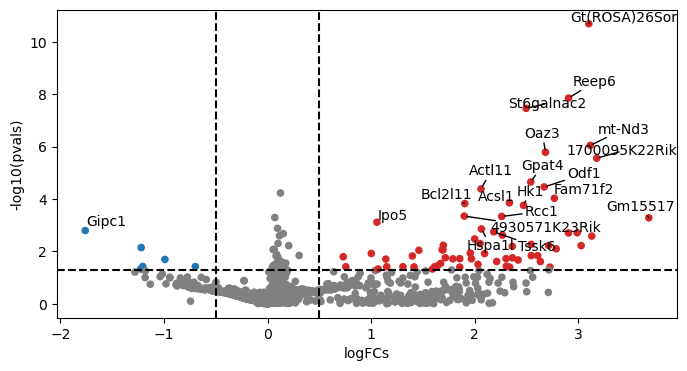

In [106]:
#For all cell types
#cell_type = pdata[pdata.obs['original_cells'] == i].copy()
cell_type = pdata.copy()
genes = dc.filter_by_expr(cell_type, group='condition', min_count=10, min_total_count=15)

# Filter by these genes
cell_type = cell_type[:, genes].copy()
# Build DESeq2 object
inference = DefaultInference(n_cpus=1)
dds = DeseqDataSet(
    counts=cell_type.X,
    metadata=cell_type.obs,
    design='~condition',
    refit_cooks=True,
    inference=inference,)
# Compute LFCs
dds.deseq2()
# Extract contrast between KO and WT
ds_KO_vs_WT = DeseqStats(
    dds,
    contrast=["condition", 'Knockout', 'WT'],
    inference=inference,
)
# Compute Wald test
ds_KO_vs_WT.summary()
ds_KO_vs_WT.lfc_shrink(coeff="condition[T.WT]")
results_df = ds_KO_vs_WT.results_df
results_df.index = cell_type.var.index

dc.plot_volcano_df(
    results_df,
    x='log2FoldChange',
    y='padj',
    top=20,
    figsize=(8, 4)
)
significant = results_df[abs(results_df['padj']) < 0.05]
sc = significant.index
sc_bulk_intersection = list(set(sc) & set(bulk['x']))

In [121]:
significant

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1700012A03Rik,82.149013,1.968012,1.354578,-3.788663,1.514605e-04,1.931224e-02
1700016H13Rik,61.748619,2.337696,0.975795,-3.496500,4.714040e-04,3.992574e-02
1700027A15Rik,556.017478,0.104527,0.717679,-3.578640,3.453873e-04,3.567942e-02
1700095A21Rik,124.774197,0.063507,0.431667,-3.475613,5.096874e-04,4.168287e-02
1700095K22Rik,220.187875,3.177898,1.081602,-5.989409,2.106054e-09,2.755771e-06
...,...,...,...,...,...,...
Ubqln3,117.707959,0.112531,0.714999,-3.517918,4.349474e-04,3.877610e-02
Wbscr25,131.075273,3.130136,0.928825,-4.425912,9.603574e-06,2.599919e-03
Wdr64,31.430172,0.111600,0.537142,-3.538370,4.026058e-04,3.806146e-02
Zmiz2,92.470534,1.141434,0.378160,-3.777627,1.583295e-04,1.973087e-02


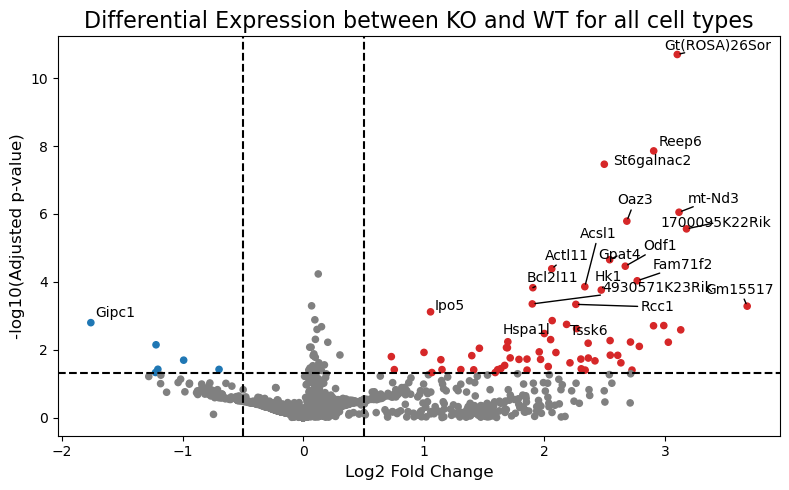

In [123]:
dc.plot_volcano_df(
    results_df,
    x='log2FoldChange',
    y='padj',
    top=20,
    figsize=(8, 5)
)

plt.title('Differential Expression between KO and WT for all cell types', fontsize=16)
plt.xlabel('Log2 Fold Change', fontsize=12)
plt.ylabel('-log10(Adjusted p-value)', fontsize=12)

plt.tight_layout()
plt.savefig('./pseudobulk_DEGs/all_cell_types.png', dpi=300)
plt.show()

In [119]:
dict_to_save = {'DEGs_for_all_celltypes': sc}
df = pd.DataFrame(dict_to_save)

In [120]:
df.to_csv('./pseudobulk_DEGs/sc_DEGs_for_all_celltypes.csv', index=False)